![{474x427}](GRR.jpg)

# Data exploration (in progress)

In [1]:
pip install gpxpy

Note: you may need to restart the kernel to use updated packages.


## Imports

In [2]:
import numpy as np
import pandas as pd
import folium
import geopandas
import gpxpy
import matplotlib.pyplot as plt 
import seaborn as sns

## Loading data

In [3]:
athletes=pd.read_csv('./1 - scraping/datasets/athletes.csv')
athletes.head()

,num_dossard,pname,name,genre,cat,club,nationalité,ville,pays,etat,class_gen,class_F,class_cat,arrivée,tps_course,vit_moy
0,1300,Daniel,JUNG,Homme,M0 H (35-39),NaN,ITA (Italie),NATURNS,IT,Finisher,1,NaN,1,20:02,23:02:21,6.96
1,2810,Ludovic,POMMERET,Homme,M2 H (45-49),NaN,FRA (France),PREVESSIN,FR,Finisher,1,NaN,1,20:02,23:02:21,6.96
2,2811,Beñat,MARMISSOLLE,Homme,M1 H (40-44),NaN,FRA (France),TARDETS-SORHOLUS (FRANCE),FR,Finisher,3,NaN,1,20:45,23:45:54,6.74
3,270,Cédric,CHAVET,Homme,M2 H (45-49),NaN,FRA (France),CIRY LE NOBLE,FR,Finisher,4,NaN,2,21:08,24:08:41,6.64
4,624,Francesco,CUCCO,Homme,M0 H (35-39),NaN,ITA (Italie),CHAMBÉRY,FR,Finisher,5,NaN,2,21:32,24:32:42,6.53


In [4]:
performances=pd.read_csv('./1 - scraping/datasets/performances.csv')
performances.head()

,num_dossard,Point_de_passage,Vitesse,Class.,Jour/heure_de_passage,tps_course
0,1300,St Pierre Ravine Blanche,- km/h,-,Je. 21:00,00:00:00
1,1300,Domaine Vidot,"12,59 km/h",11,Je. 22:09,01:09:26
2,1300,Notre Dame de la Paix,"7,62 km/h",7,Je. 23:31,02:31:01
3,1300,Parking Aire Nez de Boeuf,"8,46 km/h",3,Ve. 01:09,04:09:43
4,1300,Mare à Boue,"9,39 km/h",3,Ve. 02:15,05:15:57


In [5]:
etapes=pd.read_csv('./1 - scraping/datasets/etapes.csv')
etapes.head()

,NOM ETAPE,ETAPE PREC.,NUM ETAPE,ALTITUDE,DIST. DEPUIS LE DÉPART (KM),DIST. DEPUIS PRECEDENT (KM),D+ DEPUIS LE DÉPART (M),D+ DEPUIS DOMAINE PRECEDENT (M),LATITUDE,LONGITUDE
0,ST PIERRE RAVINE BLANCHE,NaN,0,3,0.0,0.0,0,0,-21.334487,55.462572
1,DOMAINE VIDOT,ST PIERRE RAVINE BLANCHE,1,650,14.6,14.6,663,663,-21.312118,55.548562
2,NOTRE DAME DE LA PAIX,DOMAINE VIDOT,2,1602,24.9,10.4,1687,1024,-21.248885,55.598994
3,PARKING AIRE NEZ DE BOEUF,NOTRE DAME DE LA PAIX,3,2018,38.8,13.9,2440,753,-21.204996,55.616795
4,MARE À BOUE,PARKING AIRE NEZ DE BOEUF,4,1601,49.2,10.4,2511,71,-21.160180,55.570757


## 0 - Data prep

### Performances dataset

#### Formatting NOM ETAPE and point_de_passage for joins

In [6]:
performances['Point_de_passage']=performances['Point_de_passage'].astype('str')
performances['NOM ETAPE']=performances['Point_de_passage'].apply(lambda x:x.upper())
performances.drop('Point_de_passage',inplace=True,axis=1)

#### Cleaning feature 'Vitesse' for computations

In [7]:
performances['Vitesse']=performances['Vitesse'].apply(lambda x:x.replace('- km/h','0'))
performances['Vitesse']=performances['Vitesse'].apply(lambda x:x.replace(',','.'))
performances['Vitesse']=performances['Vitesse'].apply(lambda x:x.replace('km/h',''))
performances['Vitesse']=performances['Vitesse'].astype('float')
performances['Vitesse']=round(performances['Vitesse'],2)

#### Creation of a feature 'allure moyenne' (min/km) for each segment

In [8]:
non_zero=performances[performances['Vitesse']!=0]
performances['allure_moy']=non_zero['Vitesse'].apply(lambda x:round(divmod(60/x,1)[0]+divmod(60/x,1)[1]*60/100),2)

### Athletes dataset

#### Creation of a feature 'allure moyenne' (min/km) for each athlete

In [9]:
athletes['allure_moy']=athletes['vit_moy'].apply(lambda x:round(divmod(60/x,1)[0]+divmod(60/x,1)[1]*60/100,2))

#### Creation of a feature 'tranche age' (age groups) based on athletes categories 

In [10]:
athletes['tranche_age']=athletes['cat'].apply(lambda x:x[-6:-1])

#### Changing types for computations

In [11]:
athletes['tranche_age']=athletes['tranche_age'].astype('str')
athletes['genre']=athletes['genre'].astype('str')
athletes['allure_moy']=athletes['allure_moy'].astype('float')

### Etapes dataset

#### Changing types for computations

In [12]:
etapes['NUM ETAPE']=etapes['NUM ETAPE'].astype('int')
etapes['ALTITUDE']=etapes['ALTITUDE'].astype('int')
etapes['DIST. DEPUIS LE DÉPART (KM)']=etapes['DIST. DEPUIS LE DÉPART (KM)'].astype('float')
etapes['DIST. DEPUIS PRECEDENT (KM)']=etapes['DIST. DEPUIS PRECEDENT (KM)'].astype('float')
etapes['D+ DEPUIS LE DÉPART (M)']=etapes['D+ DEPUIS LE DÉPART (M)'].astype('int')
etapes['D+ DEPUIS DOMAINE PRECEDENT (M)']=etapes['D+ DEPUIS DOMAINE PRECEDENT (M)'].astype('int')
etapes['LATITUDE']=etapes['LATITUDE'].astype('float')
etapes['LONGITUDE']=etapes['LONGITUDE'].astype('float')

### Merged dataset

#### Creation of a unique merged dataset

In [13]:
main_df=performances.merge(etapes,on='NOM ETAPE')

main_df['SEGMENT']= main_df['ETAPE PREC.'] + '-' + main_df['NOM ETAPE']

main_df=main_df.merge(athletes.drop(['vit_moy','allure_moy'],axis=1),on='num_dossard')

## 1 - Race circuit visualization

#### Function for  processing gpx file to create the race track

In [14]:
def process_gpx_to_df(file_name):
    gpx = gpxpy.parse(open(file_name)) 

    #(1)make DataFrame
    track = gpx.tracks[0]
    segment = track.segments[0]
    # Load the data into a Pandas dataframe (by way of a list)
    data = []
    segment_length = segment.length_3d()
    for point_idx, point in enumerate(segment.points):
        data.append([point.longitude, point.latitude,point.elevation,
        point.time, segment.get_speed(point_idx)])
        columns = ['Longitude', 'Latitude', 'Altitude', 'Time', 'Speed']
        gpx_df = pd.DataFrame(data, columns=columns)

    #2(make points tuple for line)
    points = []
    for track in gpx.tracks:
        for segment in track.segments: 
            for point in segment.points:
                points.append(tuple([point.latitude, point.longitude]))

    return gpx_df, points

#### Actual processing of the gpx file (time consuming!)

In [15]:
%%time 
gpx_df, points=process_gpx_to_df('./grand-raid-de-la-reunion-2021-diagonale-des-fous-sur-tracedetrail-fr_169.gpx')

CPU times: total: 7min 16s
Wall time: 7min 20s


#### Creation of a folium map centered on the race track middle

In [16]:
mymap = folium.Map( location=[ gpx_df.Latitude.mean(), gpx_df.Longitude.mean() ], zoom_start=10, tiles=None)
folium.TileLayer('openstreetmap', name='OpenStreet Map').add_to(mymap)

#### Displaying the race track on the map

In [17]:
folium.PolyLine(points, color='red', weight=4.5, opacity=.5).add_to(mymap)

#### Creating a green start icon on the map

In [18]:
start_pop_up='start'
lat_start=points[0][0]
long_start=points[0][1]
popup = folium.Popup(start_pop_up, max_width=400)
#nice green circle
folium.vector_layers.CircleMarker(location=[lat_start, long_start], radius=9, color='white', weight=1, fill_color='green', fill_opacity=1, popup=start_pop_up).add_to(mymap) 
#OVERLAY triangle
folium.RegularPolygonMarker(location=[lat_start, long_start], 
fill_color='white', fill_opacity=1, color='white', number_of_sides=3, 
radius=3, rotation=0, popup=start_pop_up).add_to(mymap)

#### Creating a red end icon on the map

In [19]:
end_pop_up = 'End'
lat_end=points[-1][0]
long_end=points[-1][1]
folium.vector_layers.CircleMarker(location=[lat_end, long_end], radius=9, color='white', weight=1, fill_color='red', fill_opacity=1, popup=end_pop_up).add_to(mymap) 
#OVERLAY square
folium.RegularPolygonMarker(location=[lat_end, long_end], 
fill_color='white', fill_opacity=1, color='white', number_of_sides=4, 
radius=3, rotation=45, popup=end_pop_up).add_to(mymap)

folium.LayerControl(collapsed=True).add_to(mymap)

#### Creating icons for supply points

In [20]:
for i,row in etapes.iterrows():
    stop_data = row[:-2].reset_index()
    lat=row[-2]
    long=row[-1]
    html_title = "<div align='center'><h5>Infos étape</h5><br></div>"
    html = html_title + "<div align='center'>" + stop_data.to_html(justify='center', header=False, index=False, index_names=False, col_space=300, decimal=',',classes='table-condensed table-responsive table-light') + "</div>" #
    popup = folium.Popup(html, max_width=300)
    folium.Marker([lat, long], popup=popup, icon=folium.Icon(color='darkblue', icon_color='white', icon='glass', prefix='fa')).add_to(mymap)

#### FInal result, saving and displaying the map

In [21]:
mymap.save("Diag.html")
mymap

## 2 - Data viz EDA

### 2.1 Athletes dataset descriptive statistics for age and genre. Trail: a masculin sport ?

#### Creating a grouped view by age and genre 

In [22]:
viz_1=athletes.groupby(['genre','tranche_age']).agg(allure_moy=('allure_moy','mean'),
                                                    num=('num_dossard','count')).reset_index()

In [23]:
viz_1['allure_moy']=round(viz_1['allure_moy'],1)

Here we use an approximation of the mean pace. The decimal numbers are in fact a % of pace and not a proper pace.

#### Filliing empty age groups for women with zero

In [24]:
labels = viz_1['tranche_age'].value_counts().reset_index()
for i,row in labels.iterrows():
    if row[1]==1:
        viz_1.loc[len(viz_1.index)] = ['Femme', row[0], 0,0]

#### Separating by genre 

In [25]:
viz_1.sort_values(by=['tranche_age'], inplace=True)
femmes=viz_1[viz_1['genre']=='Femme'].drop('genre',axis=1)
hommes=viz_1[viz_1['genre']=='Homme'].drop('genre',axis=1)

#### 2.1.1 Plotting a compared view of mean pace per genre and age

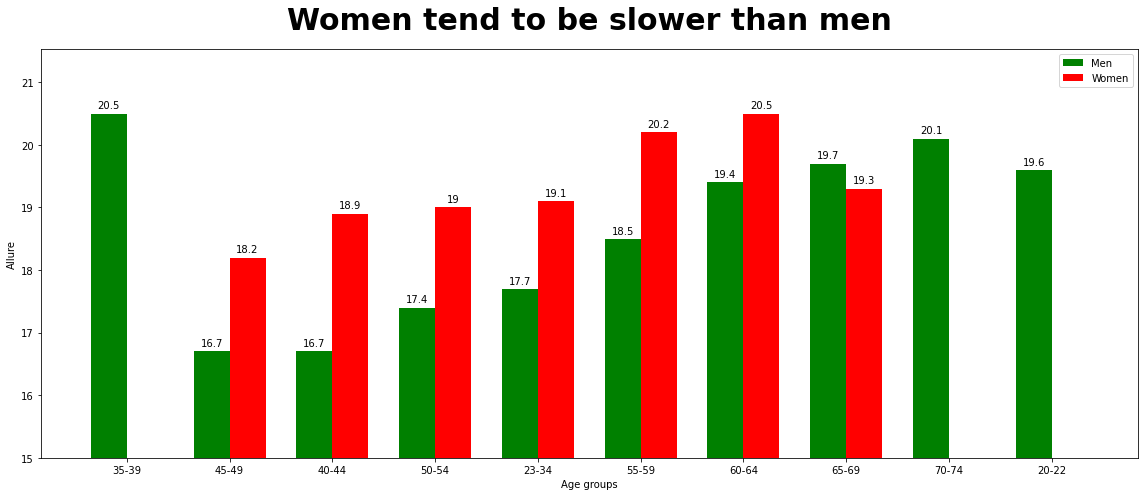

In [26]:
# creating a plot with 2 by 2 subplots
fig, ax = plt.subplots(figsize=(16,7))

labels = athletes['tranche_age'].unique()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, hommes['allure_moy'], width, label='Men',color="green")
rects2 = ax.bar(x + width/2, femmes['allure_moy'], width, label='Women',color="red")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Allure')
ax.set_xlabel('Age groups')
ax.set_title('Women tend to be slower than men', fontweight="bold", fontsize=30, pad=20)
ax.set_xticks(x, labels)
ax.legend()
ax.set_ylim(15,)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

#### 2.1.2 Plotting a compared view of number of participants per genre and age

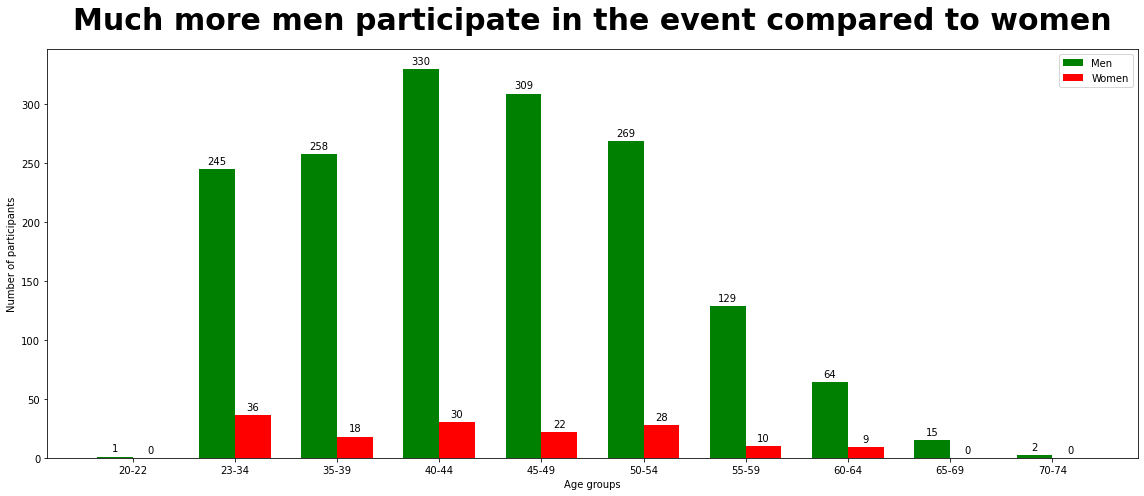

In [27]:
# creating a plot with 2 by 2 subplots
fig, ax = plt.subplots(figsize=(16,7))

labels = viz_1['tranche_age'].unique()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, hommes['num'], width, label='Men',color="green")
rects2 = ax.bar(x + width/2, femmes['num'], width, label='Women',color="red")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of participants')
ax.set_xlabel('Age groups')
ax.set_title('Much more men participate in the event compared to women', fontweight="bold", fontsize=30, pad=20)
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

$\color{red}{\text{Ultra trail, or at least this race,  seems indeed to be mainly appealing to men.}}$

### 2.2 Athletes dataset: time to finish the race 

#### Selecting only finishers and transforming the time feature format

In [28]:
Finishers=athletes[athletes['etat']=='Finisher']
def to_hours(x):
    x=str(x)
    splt=x.split(':')
    hrs=round(float(splt[0])+float(splt[1])/60,1)
    return hrs

athletes['tps_course_heures']=Finishers['tps_course'].apply(lambda x:to_hours(x))

#### Preparing time bins for visualiztion

In [29]:
athletes['finisher_group'] = pd.cut(athletes['tps_course_heures'], bins=[20, 25, 30, 35, 40,45,50,55,60, float('Inf')], labels=['<25', '25-30','30-35','35-40','40-45','45-50','50-55','55-60', '60+'])

#### Raw statistics for the race

$\color{red}{\text{Here we can already observe a huge gap between the Elites wrapping up the 
race in less than 30 hours whereas the average athlete needs 48 hours to finish !}}$

In [30]:
athletes['tps_course_heures'].describe()

count    1774.000000
mean       48.165727
std         8.324447
min        23.000000
25%        42.400000
50%        47.900000
75%        54.975000
max        66.700000
Name: tps_course_heures, dtype: float64

#### Preparing the color palette for visualization

In [31]:
brew_palette=sns.choose_colorbrewer_palette('diverging')

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

#### 2.2.1 Finishing time distribution

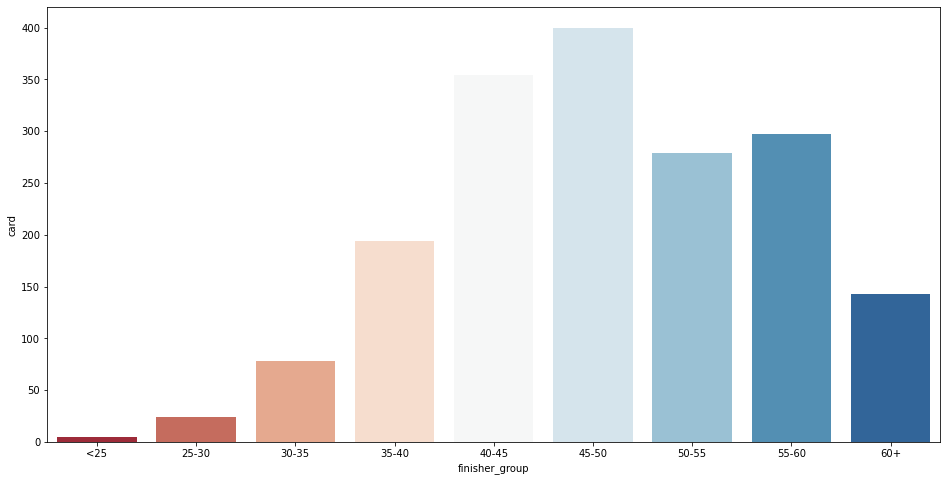

In [32]:
# creating a plot with 2 by 2 subplots
fig, ax = plt.subplots(figsize=(16,8))
#  Allures femmes
g = sns.barplot(y="card", x="finisher_group",data=athletes.groupby('finisher_group').agg(card=('num_dossard','count')).reset_index(),palette=brew_palette)
# ax.set_ylabel("allure_moy")
# ax[0,0].set_xlabel("tranche_age", size=20,fontweight="bold")
# ax.set_title("Allures Femmes", size=25,fontweight="bold")
# ax.grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)
# ax.set_ylim([15, 21])


$\color{red}{\text{Knowing the difficulty of the race and the preparation of all athletes (even amateurs) we can only be amazed at the performance of top atheltes finishing the race in less than 30 or even 35 hours !}}$

### 2.3 - Segments difficulty

#### Creating a grouped view on segments

In [33]:
seg_perf=main_df.groupby(['SEGMENT','NUM ETAPE','D+ DEPUIS DOMAINE PRECEDENT (M)','DIST. DEPUIS PRECEDENT (KM)']).agg(allure=('allure_moy','mean')).sort_values('NUM ETAPE').reset_index()

In [34]:
seg_perf['allure']=round(seg_perf['allure'],1)
seg_perf['D+ par km']=round(seg_perf['D+ DEPUIS DOMAINE PRECEDENT (M)']/seg_perf['DIST. DEPUIS PRECEDENT (KM)'],1)

#### D+ as proxies for difficulty

$\color{red}{\text{We can define the difficulty as the mean allure to complete a segment. Here we can see that D+ seems to be a good proxy for the difficulty of a segment. Other factors could be, time of day (light and temperature), distance, and D- . }}$



<AxesSubplot:xlabel='D+ par km', ylabel='allure'>

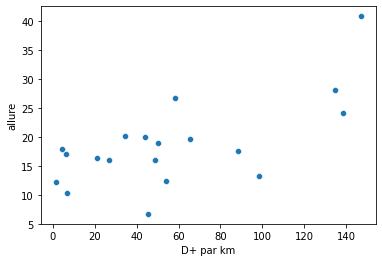

In [35]:
sns.scatterplot(data=seg_perf[['allure','D+ par km']], x="D+ par km", y="allure")

### Next Steps

- Enrich dataset with strava data if available
- Enrich dataset with temperature and light per segment per athlete (wheather data per hour per location) 
- Enrich dataset and compare with older editions 
- study where ranking and distance vary the most between athletes 
- Study race plan optimizations
- Allowing to have a filtered display by athlete on the map with a colored indication of time of day / light / temperature

mettre en face les températures => récupérer les données météorologique en fonction du lieu et de l'heure 

### Sources

- https://towardsdatascience.com/build-interactive-gps-activity-maps-from-gpx-files-using-folium-cf9eebba1fe7
- https://www.grandraid-reunion.com/francais/resultats/?annee=2021&course=GR
- https://www.visugpx.com/HENYVzOHZv